In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

# Overview and big Idea
**Anomaly Detection**: Identification of items, events or observations which is significantly different from the remaining data.
- Non-parametric approach
- Frequency or counting based
    - How many time a value of variable (e.g. ip address) shows up
    - More frequent - less likely to be an anomaly
    - less frequent - more likely to be an anomaly
    - Calculate probability
    
    <br>
    
- Conditional probability $$ {P(A|B) = }\frac{\text{P(A U B)}}{\text{P(B)}} $$

<br>

- Examples:
    - How many times we see an ip address in the dataset 
        - count how many times that ip address logs in
    - What is probability of ip address showing up in the dataset 
        - ip count / total observations
    - Conditional probability. Given an ip address, what is prob of a particular status
        - probability of A, given that B is true
        - e.g authentication failure

<hr style="border:2px solid black"> </hr>

In [2]:
#specify column names
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
#create a df reading the csv
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df_orig.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
#take a look at the df
df_orig.shape

(13974, 7)

In [5]:
#create new df with FAKE data
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

#append FAKE data to original df (will be at the bottom)
df = df_orig.append(new)

In [6]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Parse Datetime

In [8]:
pd.to_datetime('16/Apr/2019 19:34:42')

Timestamp('2019-04-16 19:34:42')

In [9]:
#clean up the timestamp by removing the brackets and trailing zeros
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [10]:
# replace the first colon in the timestamp before year 
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [11]:
# set datetime index and sort
df = df.set_index('timestamp').sort_index()

In [12]:
### Now date time is set as index and sorted correctly

### Cleanup text

In [13]:
#take quotations out of 'request_method', 'request_agent and 'destination' columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

#get rid of page numbers and following data from 'request_method' colum    
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [14]:
# convert bytes to megabytes (as new column)
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [15]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [16]:
#now that we have new column with size as MB
#drop the size column- 'size' is a reserved word
df.drop(columns= 'size', inplace = True)

In [17]:
#look at new column and clean data
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [18]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


<hr style="border:2px solid black"> </hr>

## Detecting Anomalies in Discrete Variables
- more frequently something appears, the less likely it is to be an anomaly

In [19]:
#check how many unique ip addresses we have
df.ip.nunique()

22

In [20]:
#check how many times each ip address logs in
#keeping nan values
df.ip.value_counts(dropna=False)

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
35.175.171.137        2
52.87.230.102         2
70.121.214.34         2
52.91.30.150          1
95.31.16.121          1
3.92.201.136          1
97.105.15.120         1
95.31.18.119          1
45.23.250.16          1
54.145.52.184         1
52.90.165.200         1
3.88.129.158          1
34.207.64.242         1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
Name: ip, dtype: int64

In [21]:
#turn above value into df
df.ip.value_counts(dropna=False).reset_index()

,index,ip
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.91.30.150,1


In [22]:
#correct labels on df to match values
#shows how many times the ip shows up
df.ip.value_counts(dropna=False).reset_index().rename(columns ={'index': 'ip', 'ip': 'count'})

,ip,count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21
5,68.201.219.223,21
6,35.175.171.137,2
7,52.87.230.102,2
8,70.121.214.34,2
9,52.91.30.150,1


In [23]:
#get the counts of ips in the dataset
#assign to new variable
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [24]:
#take a look
ip_df.head()

,ip,ip_count
0,97.105.19.58,11999
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [25]:
# calculate probabity for each ip 
#ip_prob = count for each ip / total count in the dataframe
#each count divided by total

#new variable that takes df and value counts/total count (proba)
#rename columns
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df2.head()

,ip,ip_proba
0,97.105.19.58,0.858420
1,173.173.113.51,0.075762
2,72.181.113.170,0.043855
3,72.181.105.81,0.017599
4,24.26.242.9,0.001502


In [26]:
# merge the two data frames create above into a single one:
#includes count and probability dfs
ip_df = ip_df.merge(ip_df2)
ip_df.head()

,ip,ip_count,ip_proba
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502


In [27]:
# look at rows where ip_proba is less than 0.01
ip_df[ip_df.ip_proba < 0.01]

,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,52.87.230.102,2,0.000143
8,70.121.214.34,2,0.000143
9,52.91.30.150,1,0.000072
10,95.31.16.121,1,0.000072
11,3.92.201.136,1,0.000072
12,97.105.15.120,1,0.000072
13,95.31.18.119,1,0.000072


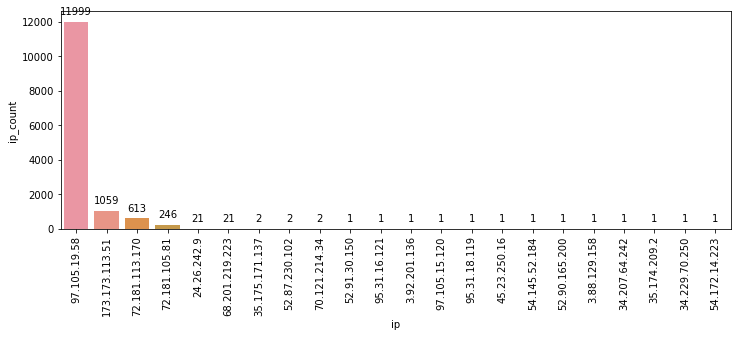

In [28]:
# plot the ip_count for each ip

#visualize the ip address and count of each login
#exponential decay
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives

### Establish Baseline

In [29]:
#new data points came in
#train is those new data points
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [30]:
train.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [31]:
#size of train/size of entire df
train.size /df.size

0.9997138360280441

In [32]:
#Compute probabilities based on train sample:

#value count/total count
#reset index
#rename columns
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

#take a look, just proba of train
ip_df.head()

,ip,ip_proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [33]:
#take a look at the dfs you want to join
ip_df.shape, df.shape

((19, 2), (13978, 6))

In [34]:
#Merge probabilities with all data (train + new data):
#Where the IP address is new, i.e. not seen in the training 

#all columns, left join on ip
#reset index to get away from datatime index
#fill nulls with 0
#set index again to datetime

df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.tail(5)

,ip,request_method,status,destination,request_agent,size_mb,ip_proba
timestamp,,,,,,,
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486532,0.858595
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.858595
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000


### Takeaways:
- probability was filled with 0 if row was empty
- destination was turn to 0 from nan
- joined tables together

<hr style="border:2px solid black"> </hr>

## Conditional Probability
- 2 discrete variables

### Example
- conditional proba. proba of A given B
- prob(A|B) = prob(A &B)/prob(B)

In [35]:
#group by ip
#get size of ip
#divide by total
ip_probs = train.groupby('ip').size().div(len(train))
ip_probs

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
34.229.70.250     0.000072
35.174.209.2      0.000072
35.175.171.137    0.000143
45.23.250.16      0.000072
52.87.230.102     0.000143
52.90.165.200     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
54.172.14.223     0.000072
68.201.219.223    0.001503
70.121.214.34     0.000143
72.181.105.81     0.017604
72.181.113.170    0.043867
97.105.19.58      0.858595
dtype: float64

In [36]:
#probability of B
Pb = train.groupby('ip').size().div(len(train))
#probability of AB
Pab = train.groupby(['ip', 'status']).size().div(len(train))

#prob(A|B)
Pab.div(Pb, axis=0, level= 'ip')

ip              status
173.173.113.51  200       1.000000
24.26.242.9     200       1.000000
3.88.129.158    200       1.000000
3.92.201.136    200       1.000000
34.207.64.242   200       1.000000
34.229.70.250   200       1.000000
35.174.209.2    200       1.000000
35.175.171.137  200       1.000000
45.23.250.16    200       1.000000
52.87.230.102   200       1.000000
52.90.165.200   200       1.000000
52.91.30.150    200       1.000000
54.145.52.184   200       1.000000
54.172.14.223   200       1.000000
68.201.219.223  200       1.000000
70.121.214.34   200       1.000000
72.181.105.81   200       1.000000
72.181.113.170  200       0.996737
                499       0.003263
97.105.19.58    200       0.998833
                499       0.001167
dtype: float64

In [37]:
# Conditional probability. Given an ip address, what is prob of a particular status
status_given_ip = pd.DataFrame(train.groupby(['ip', 'status']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_ip'})
                              )

status_given_ip

,ip,status,proba_status_given_ip
0,173.173.113.51,200,1.000000
1,24.26.242.9,200,1.000000
2,3.88.129.158,200,1.000000
3,3.92.201.136,200,1.000000
4,34.207.64.242,200,1.000000
5,34.229.70.250,200,1.000000
6,35.174.209.2,200,1.000000
7,35.175.171.137,200,1.000000
8,45.23.250.16,200,1.000000
9,52.87.230.102,200,1.000000


In [38]:
# calculate count for each combination of ip and status
ip_status_count = pd.DataFrame(train.groupby(['ip', 'status'])['request_method'].\
                              count().reset_index().\
                              rename(columns={'request_method': 'ip_status_count'}))

# merge ip_status_count with status_given_ip dataframe

ip_status = status_given_ip.merge(ip_status_count)
ip_status

,ip,status,proba_status_given_ip,ip_status_count
0,173.173.113.51,200,1.000000,1059
1,24.26.242.9,200,1.000000,21
2,3.88.129.158,200,1.000000,1
3,3.92.201.136,200,1.000000,1
4,34.207.64.242,200,1.000000,1
5,34.229.70.250,200,1.000000,1
6,35.174.209.2,200,1.000000,1
7,35.175.171.137,200,1.000000,2
8,45.23.250.16,200,1.000000,1
9,52.87.230.102,200,1.000000,2


#### Add these probabilities to original events to detect anomalous events

In [39]:
df = df.reset_index().merge(ip_status, on=['ip', 'status'], how='left').fillna(value=0).set_index('timestamp')

df

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.858595,0.998833,11984.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.858595,0.998833,11984.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.858595,0.998833,11984.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.858595,0.998833,11984.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.858595,0.998833,11984.0
...,...,...,...,...,...,...,...,...,...
2019-04-17 12:55:14,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486532,0.858595,0.998833,11984.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0


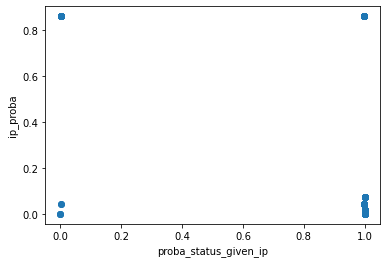

In [40]:
#plot the probabilities
#probability of ip address happening
#probability of status given that ip address
plt.scatter(df.proba_status_given_ip, df.ip_proba)
plt.xlabel('proba_status_given_ip')
plt.ylabel('ip_proba');

In [41]:
#lower left cluster: low ip address, status low (anomaly)
df[(df['proba_status_given_ip'] < 0.2) & (df['ip_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-17 02:48:36,72.181.113.170,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.043867,0.003263,2.0
2019-04-17 03:42:44,72.181.113.170,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.043867,0.003263,2.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0


In [42]:
#lower right cluster: low ip address, status high
df[(df['proba_status_given_ip'] > 0.8) & (df['ip_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-16 19:39:14,3.92.201.136,GET / HTTP/1.1,200,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000040,0.000072,1.0,1.0
2019-04-16 19:39:15,52.90.165.200,GET /favicon.ico HTTP/1.1,200,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:32,3.88.129.158,GET /api/v1/items HTTP/1.1,200,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.003396,0.000072,1.0,1.0
2019-04-16 19:40:33,34.207.64.242,GET /favicon.ico HTTP/1.1,200,0,Slackbot 1.0 (+https://api.slack.com/robots),0.000154,0.000072,1.0,1.0
2019-04-16 19:40:36,54.172.14.223,GET /api/v1/ HTTP/1.1,200,0,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000154,0.000072,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2019-04-17 06:15:07,24.26.242.9,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.471025,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.001503,1.0,21.0
2019-04-17 06:16:10,24.26.242.9,GET /api/v1/stores HTTP/1.1,200,0,python-requests/2.21.0,0.001266,0.001503,1.0,21.0


In [43]:
#upper right cluster: high ip address, status low (frequent user)
df[(df['proba_status_given_ip'] < 0.8) & (df['ip_proba'] > 0.8)]

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0
2019-04-16 19:56:02,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0
2019-04-16 20:28:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:33:24,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:38:13,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:38:55,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:39:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:45:17,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:45:28,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0


In [44]:
#upper left cluster: high ip address, status low
df[(df['proba_status_given_ip'] < 0.2) & (df['ip_proba'] > 0.8)]

,ip,request_method,status,destination,request_agent,size_mb,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2019-04-16 19:55:15,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0
2019-04-16 19:56:02,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.20.1,0.0,0.858595,0.001167,14.0
2019-04-16 20:28:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:33:24,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:38:13,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:38:55,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:39:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:45:17,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
2019-04-16 20:45:28,97.105.19.58,GET /api/v1/sales HTTP/1.1,499,0,python-requests/2.21.0,0.0,0.858595,0.001167,14.0
